In [ ]:
import sys
from pathlib import Path
current_dir = Path().resolve()
sys.path.append(current_dir.parent.parent.as_posix())

import os

# %% General setup
import pandas as pd
from pathlib import Path
from data_io import DataIO

import utils
import numpy as np
from utils import make_figure, save_fig
from scipy.stats import wilcoxon
from BU_hydrogel.project_colors import ProjectColors
from BU_hydrogel.analysis.analysis_params import dataset_dir, figure_dir_analysis


# Load data
session_id = '2025-12-16 rat P23H 3318 B'
figure_dir_analysis = figure_dir_analysis / session_id

if not os.path.exists(figure_dir_analysis):
    os.makedirs(figure_dir_analysis)

data_io = DataIO(dataset_dir)
data_io.load_session(session_id, load_pickle=False, load_waveforms=False)
data_io.dump_as_pickle()

loadname = dataset_dir / f'{session_id}_cells.csv'
cells_df = pd.read_csv(loadname, header=[0, 1], index_col=0)
clrs = ProjectColors()

INCLUDE_RANGE = 50  # include cells at max distance = 50 um

### Select the recordings to analyse

In [6]:
# Print available recording ids
print("Available recording ids:")
for rec_id in data_io.recording_ids:
    print(f"- {rec_id}")


Available recording ids:
- rec_1_2025-16-12_rat_3318_B_stim_buSTIM1


### Detect the electrode stimulation site with the most significant responses, per cell

In [7]:
# %% Detect electrode stim site with most significant responses, per cell
pref_ec_dict = {}

for cluster_id in data_io.cluster_df.index.values:
    pref_ec = None
    n_sig_pref_ec = None

    max_fr = None
    for ec in data_io.burst_df.electrode.unique():
        if pd.isna(ec):
            continue

        df = data_io.burst_df.query(f'electrode == {float(ec)}')
        tids = df.train_id.unique()
        n_sig = 0
        for tid in tids:
            if cells_df.loc[cluster_id, (tid, 'is_significant')] is True:
                n_sig += 1

        if n_sig > 1:
            if pref_ec is None or n_sig > n_sig_pref_ec:
                pref_ec = ec
                n_sig_pref_ec = n_sig
            elif n_sig == n_sig_pref_ec:
                print(f'cluster {cluster_id} has 2 pref ecs')

    if n_sig_pref_ec is None:
        print(f'\tcluster {cluster_id} has no sig responses')

        

    pref_ec_dict[cluster_id] = pref_ec


print('Electrode stimulation site with the most significant responses per cell detected.\n\n------ End Of Cell ------')

	cluster uid_2025-12-16 rat P23H 3318 B_001 has no sig responses
	cluster uid_2025-12-16 rat P23H 3318 B_002 has no sig responses
	cluster uid_2025-12-16 rat P23H 3318 B_003 has no sig responses
	cluster uid_2025-12-16 rat P23H 3318 B_004 has no sig responses
	cluster uid_2025-12-16 rat P23H 3318 B_005 has no sig responses
	cluster uid_2025-12-16 rat P23H 3318 B_006 has no sig responses
	cluster uid_2025-12-16 rat P23H 3318 B_012 has no sig responses
	cluster uid_2025-12-16 rat P23H 3318 B_013 has no sig responses
cluster uid_2025-12-16 rat P23H 3318 B_014 has 2 pref ecs
	cluster uid_2025-12-16 rat P23H 3318 B_015 has no sig responses
	cluster uid_2025-12-16 rat P23H 3318 B_016 has no sig responses
	cluster uid_2025-12-16 rat P23H 3318 B_017 has no sig responses
	cluster uid_2025-12-16 rat P23H 3318 B_018 has no sig responses
	cluster uid_2025-12-16 rat P23H 3318 B_019 has no sig responses
	cluster uid_2025-12-16 rat P23H 3318 B_028 has no sig responses
	cluster uid_2025-12-16 rat P23H

### Plot the raster plots for each cell

In [8]:
##%% Plot raster plots for each individual cell, during stimulation at each electrode

cluster_ids = data_io.cluster_df.index.values

electrodes  = data_io.burst_df.electrode.unique()

print(f'saving data in: {figure_dir_analysis / "raster plots"}')

x = 0

for cluster_id in cluster_ids:

    cluster_data = utils.load_obj(dataset_dir / 'bootstrapped' / f'bootstrap_{cluster_id}.pkl')

    n_electrodes = electrodes.size

    for ec in electrodes:

        # Setup figure layout
        fig = utils.make_figure(
            width    =1,
            height   =1.5,
            x_domains={
                1: [[0.15, 0.95]],
            },
            y_domains={
                1: [[0.1, 0.9]]
            },
        )

        # Setup variables for plotting
        burst_offset   = 0
        x_plot, y_plot = [], []
        x_lines, y_lines = [], []
        yticks         = []
        ytext          = []
        pos            = dict(row=1, col=1)

        has_sig = False

        for rec_i, rec_name in enumerate(data_io.recording_ids):
            d_select = data_io.burst_df.query('electrode == @ec and '
                                                'recording_name == @rec_name').copy()

            for (bd, dc), df in d_select.groupby(['burst_duration', 'duty_cycle']):    
                train_plot_height_start = burst_offset

                tids = df.train_id.unique()
                assert len(tids) == 1
                tid = tids[0]  
                spike_times = cluster_data[tid]['spike_times']
                bins = cluster_data[tid]['bins']

                ytext.append(f'dc: {dc:.0f} bd: {bd:.0f}')

                yticks.append(burst_offset + len(spike_times) / 2)

                for burst_i, sp in enumerate(spike_times):
                    x_plot.append(np.vstack([sp, sp, np.full(sp.size, np.nan)]).T.flatten())
                    y_plot.append(np.vstack([np.ones(sp.size) * burst_offset,
                                            np.ones(sp.size)* burst_offset +1, np.full(sp.size, np.nan)]).T.flatten())
                    burst_offset += 1

                x_lines.extend([0, bd, bd, 0, 0, None])
                y_lines.extend([train_plot_height_start, train_plot_height_start,
                                burst_offset, burst_offset, train_plot_height_start, None])

        if len(x_plot) == 0:
            continue
        x_plot = np.hstack(x_plot)
        y_plot = np.hstack(y_plot)

        fig.add_scatter(
            x=x_lines, y=y_lines,
            mode='lines', line=dict(width=0.00001, color='black'),
            fill='toself', fillcolor='rgba(0, 200, 100, 0.1)',
            showlegend=False,
            **pos,
        )

        fig.add_scatter(
            x = x_plot, y = y_plot,
            mode = 'lines', line = dict(color='black', width=0.5),
            showlegend = False,
            **pos,
        )

        fig.update_xaxes(
            tickvals = np.arange(-500, 500, 100),
            title_text = f'time [ms]',
            range = [bins[0]-1, bins[-1]+1],
            **pos,
        )

        fig.update_yaxes(
            range=[0, burst_offset],
            tickvals = yticks,
            ticktext = ytext,
            **pos,
        )

        sname = figure_dir_analysis  / 'raster plots' / f'{cluster_id}' / f'{cluster_id}_{ec}'
        utils.save_fig(fig, sname, display=False, verbose=False)

        if ec == pref_ec_dict[cluster_id]:
            sname = figure_dir_analysis  / 'raster plots' / 'significant_responses' / f'{cluster_id}' 
            utils.save_fig(fig, sname, display=False, verbose=False)



saving data in: C:\BU_IDV_hydrogel\figures_analysis\2025-12-16 rat P23H 3318 B\raster plots


In [9]:
cells_df.loc[cluster_id, (tid, 'response_latency')]

np.float64(nan)

C:\Users\truikes\AppData\Local\Temp\ipykernel_21168\504352138.py:5: TqdmExperimentalWarning:

GUI is experimental/alpha



TypeError: 'tuple' object does not support item assignment

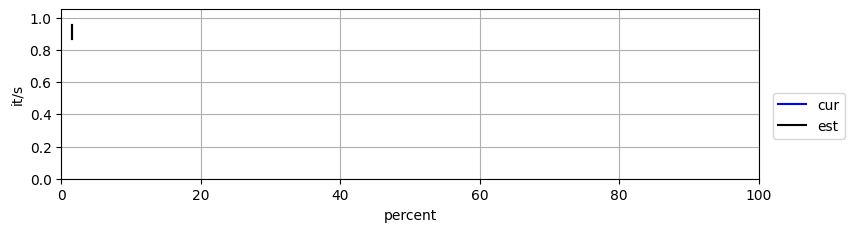

In [ ]:
##%% optimized single-panel firing rate plotting
from tqdm import tqdm 

for cluster_id in tqdm(data_io.cluster_df.index.values, desc='Plotting firing rates'):

    # Create a *single panel* figure
    fig = utils.make_figure(
        width    = 1,
        height   = 1.5,
        x_domains={1: [[0.1, 0.9],],
                   2: [[0.1, 0.9],],
                   3: [[0.1, 0.9],]
                   },
        y_domains={1: [[0.7, 0.9]], 
                   2: [[0.4, 0.6]],
                   3: [[0.1, 0.3]]},
        subplot_titles={1: ['burst duration 10'], 2: ['burst duration 30'], 3: ['burst duration 50']}
    )
    # Load data for this cluster
    cluster_data = utils.load_obj(
        dataset_dir / 'bootstrapped' / f'bootstrap_{cluster_id}.pkl'
    )

    # preferred electrode
    ec = pref_ec_dict[cluster_id]

    if ec is None:
        continue

    # Track global y-limits
    y_max = 0

    has_shaded = []

    # Loop over all recordings (all curves go on same axis)
    for rec_i, rec_name in enumerate(data_io.recording_ids):

        # Filter data
        d_select = data_io.burst_df.query(
            'electrode == @ec and recording_name == @rec_name'
        ).copy()

        for (bd, dc), df in d_select.groupby(['burst_duration', 'duty_cycle']):

            if bd == 10:
                pos = dict(row=1, col=1)
            elif bd == 30:
                pos = dict(row=2, col=1)
            elif bd == 50:
                pos = dict(row=3, col=1)
            else:
                raise ValueError('')
            

            tid  = df.train_id.iloc[0]

            clr_a = clrs.duty_cycle(dc, alpha = 0.2, dc_min=40, dc_max=50)
            clr   = clrs.duty_cycle(dc, dc_min=40, dc_max=50)

            # Load bootstrap FR data
            bins    = cluster_data[tid]['bins']
            sp      = cluster_data[tid]['firing_rate']
            ci_low  = cluster_data[tid]['firing_rate_ci_low']
            ci_high = cluster_data[tid]['firing_rate_ci_high']
            latency = cells_df.loc[cluster_id, (tid, 'response_latency')]

            if ci_high is not None:
                y_max = max(y_max, ci_high.max())

            if pos not in has_shaded:
                xp = [0, 0, bd, bd]
                yp = [0, 1000, 1000, 0]
                fig.add_scatter(
                    x=xp, y=yp, mode='lines',
                    line=dict(color='black', width=0.001),
                    fill='toself', fillcolor='rgba(100, 100, 0, 0.1)',
                    showlegend=False,
                    **pos
                )
                has_shaded.append(pos)

            if pd.notna(latency):
                fig.add_scatter(
                    x=[latency, latency],
                    y=[0, 1000],
                    line=dict(color=clr, dash='2px,2px', width=0.5),
                    showlegend=False,
                    mode='lines',
                    **pos,
                )


            # --- confidence interval ---
            fig.add_scatter(
                x=bins,
                y=ci_low,
                line=dict(width=0),
                showlegend=False,
                **pos,
            )
            fig.add_scatter(
                x=bins,
                y=ci_high,
                mode='lines',
                line=dict(width=0),
                fill='tonexty',
                fillcolor=clr_a,
                showlegend=False,
                **pos,
            )

            # --- firing-rate line ---
            show_leg = False

            fig.add_scatter(
                x=bins,
                y=sp,
                name='',
                line=dict(width=1, color=clr),
                showlegend=show_leg,
                **pos,
            )

    # Final axes formatting
    for i in range(1, 4):
        fig.update_xaxes(
            tickvals=np.arange(-500, 500, 100),
            title_text='Time (ms)',
            range=[-101, 351],
            row=i, col=1,
        )
        if y_max > 200:
            ystep = 50
        elif y_max > 100:
            ystep = 25
        else:
            ystep = 10
            
        fig.update_yaxes(
            title_text='Firing rate (Hz)',
            tickvals=np.arange(0, np.ceil(y_max/10)*10 + 1, ystep),  # nice 10-Hz spacing
            range=[0, y_max],
            row=i, col=1,
        )

    # Save figure
    sname = figure_dir_analysis / 'firing_rate_per_condition' / f'{cluster_id}'

    utils.save_fig(fig, sname, display=False, formats=['png'], verbose=False)

print(f'Saved figures in {figure_dir_analysis}')

